In [23]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from random import randrange

from random import seed
from random import random
from matplotlib import pyplot
import pandas
from pandas.plotting import autocorrelation_plot
from keras import Model
from keras.layers import GRU, Dense, Input, Dropout, LSTM, concatenate
%matplotlib inline

from numpy.random import seed as np_seed
from tensorflow import set_random_seed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

SEED = 42

seed(SEED)
np_seed(SEED)
set_random_seed(SEED)


path = '../data/'




In [6]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')


#Problems when remove index category because of multi index
#df_sds011['location'] = df_sds011['location'].astype('category')
#df_dht22['location'] = df_dht22['location'].astype('category')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

df_cars = pd.read_csv('../cars.csv', sep=';', header=None, names=['timestamp', 'n_cars'])
df_cars['timestamp'] = pd.to_datetime(df_cars['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_cars = df_cars.set_index(df_cars.timestamp, drop=True)
df_cars = df_cars.drop(columns=['timestamp'])
df_cars = df_cars.sort_index()
#df = df.groupby((pd.Grouper(freq='60min', level=0))).sum()

In [15]:
print(df_sds011.shape)
print(df_dht22.shape)
print(df_cars.shape)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())
print(df_cars.isnull().sum())

(503342, 2)
(504523, 2)
(5770, 1)
P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64
n_cars    0
dtype: int64


In [105]:
df_sds011.describe()

,P1,P2
count,503342.000000,503342.000000
mean,24.616202,17.046935
std,29.025602,19.259604
min,0.000000,0.000000
25%,6.100000,3.870000
50%,12.030000,8.600000
75%,33.800000,22.930000
max,836.100000,536.700000


In [107]:
df_dht22.describe()

,temperature,humidity
count,504523.000000,504523.000000
mean,13.431856,70.944876
std,9.470384,23.247550
min,-10.400000,5.200000
25%,6.100000,52.800000
50%,11.500000,73.500000
75%,20.200000,93.200000
max,57.800000,99.900000


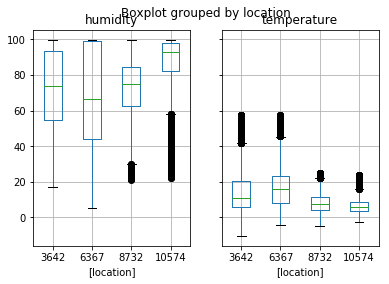

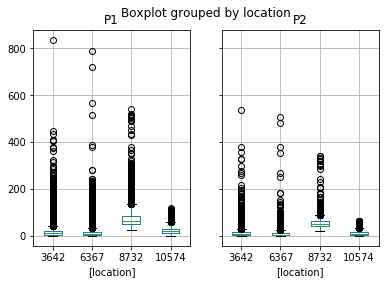

In [108]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

location
3642     AxesSubplot(0.125,0.125;0.775x0.755)
6367     AxesSubplot(0.125,0.125;0.775x0.755)
8732     AxesSubplot(0.125,0.125;0.775x0.755)
10574    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

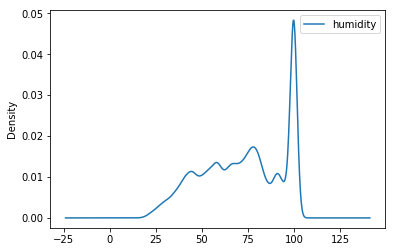

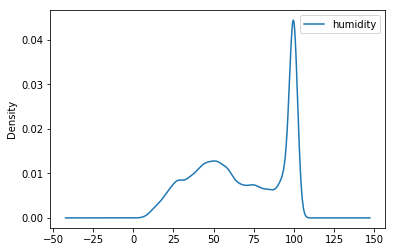

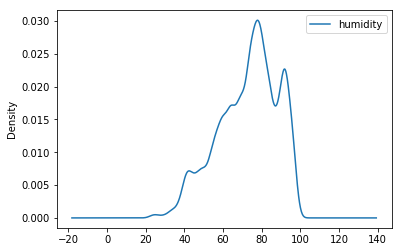

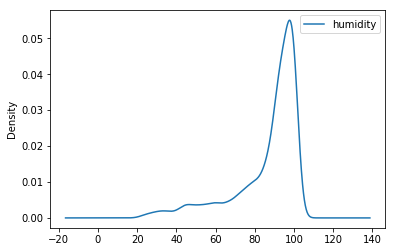

In [109]:
df_dht22.groupby(level=0)[['humidity']].plot(kind='kde')

location
3642     AxesSubplot(0.125,0.125;0.775x0.755)
6367     AxesSubplot(0.125,0.125;0.775x0.755)
8732     AxesSubplot(0.125,0.125;0.775x0.755)
10574    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

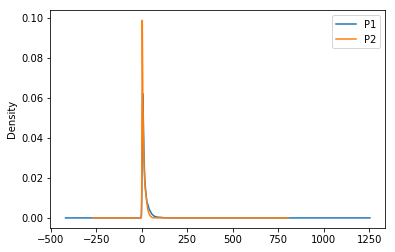

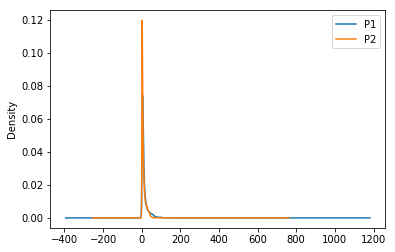

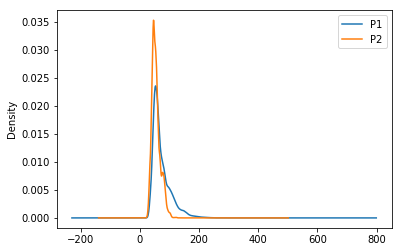

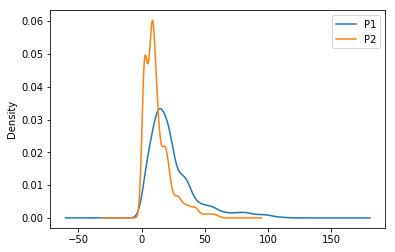

In [110]:
df_sds011.groupby(level=0).plot(kind='kde')

location
3642     AxesSubplot(0.125,0.125;0.775x0.755)
6367     AxesSubplot(0.125,0.125;0.775x0.755)
8732     AxesSubplot(0.125,0.125;0.775x0.755)
10574    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

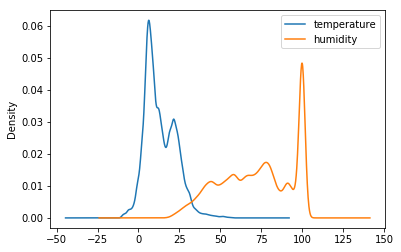

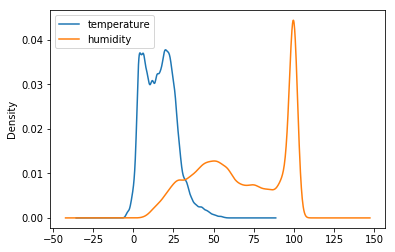

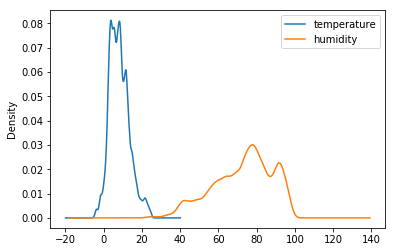

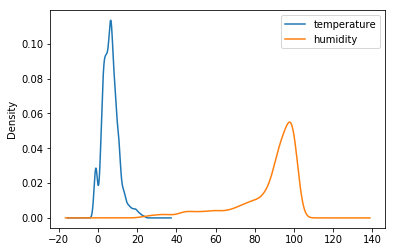

In [111]:
df_dht22.groupby(level=0).plot( kind='kde')

In [118]:
print(df_sds011.groupby(level=0).count())
print(df_dht22.groupby(level=0).count())

              P1      P2
location                
3642      256788  256788
6367      164084  164084
8732       73995   73995
10574       8475    8475
          temperature  humidity
location                       
3642           256892    256892
6367           165130    165130
8732            74001     74001
10574            8500      8500


# Drop unnecessary  data 

In [7]:
df_sds011 = df_sds011.drop([3123, 10574], level=0)
df_dht22 = df_dht22.drop([3123, 10574], level=0)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


# Outliers

In [8]:
def remove_outlier(df):
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    #print(res.groupby(level=0).count())
    return res.dropna()


print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

print(df_sds011.shape)
print(df_dht22.shape)

print('NaNs')
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

(494867, 2)
(496023, 2)
(482668, 2)
(491597, 2)
NaNs
P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


In [122]:
df_sds011.describe()

,P1,P2
count,482668.000000,482668.000000
mean,21.827503,15.569920
std,22.901968,16.647961
min,0.000000,0.000000
25%,5.930000,3.800000
50%,11.430000,8.230000
75%,30.500000,21.150000
max,112.100000,75.200000


In [135]:
df_dht22.describe()

,temperature,humidity
count,472139.000000,472139.000000
mean,13.466294,70.984304
std,9.129547,22.935422
min,-10.400000,5.200000
25%,6.100000,52.800000
50%,11.900000,73.200000
75%,20.500000,93.000000
max,42.500000,99.900000


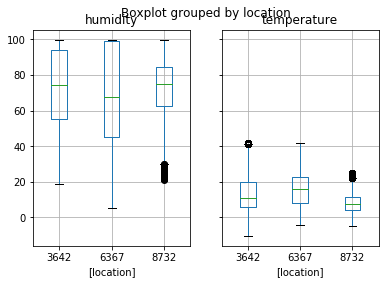

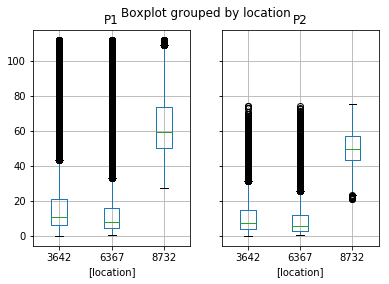

In [127]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

location
3642    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
6367    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
8732    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

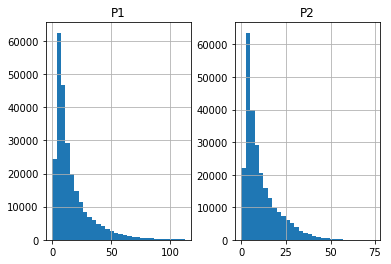

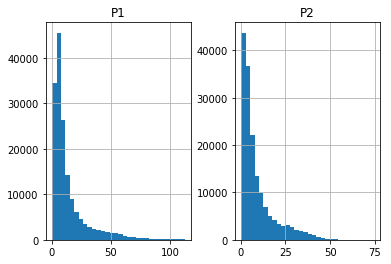

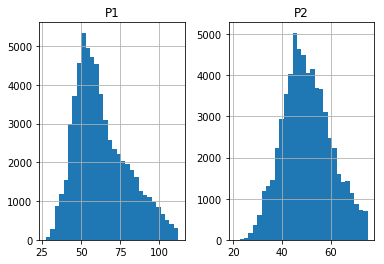

In [128]:
df_sds011.groupby(level=0).hist(bins=30)

location
3642    AxesSubplot(0.125,0.125;0.775x0.755)
6367    AxesSubplot(0.125,0.125;0.775x0.755)
8732    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

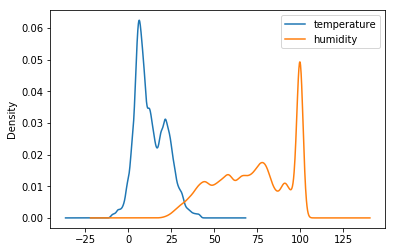

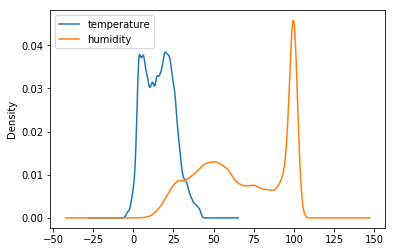

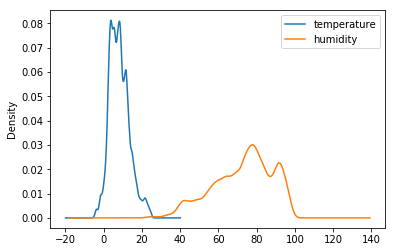

In [124]:
df_dht22.groupby(level=0).plot(kind='kde')

In [125]:
df_sds011.groupby(level=0).describe()

P1                                                            \
             count       mean        std    min    25%    50%    75%     max   
location                                                                       
3642      255815.0  16.539339  16.223786   0.00   6.07  10.63  21.00  112.10   
6367      163493.0  14.142337  16.241598   0.47   4.60   8.10  16.07  112.07   
8732       63360.0  63.009042  17.057541  27.50  50.37  59.33  73.87  112.10   

                P2                                                          
             count       mean       std    min    25%    50%    75%    max  
location                                                                    
3642      255815.0  10.963672  9.510509   0.00   3.97   7.60  14.97  74.27  
6367      163493.0   9.265829  9.732985   0.40   2.70   5.47  11.80  74.33  
8732       63360.0  50.434535  9.896456  20.83  43.50  49.63  57.00  75.20

In [126]:
df_dht22.groupby(level=0).describe()

temperature                                                    \
               count       mean       std   min  25%   50%   75%   max   
location                                                                 
3642        255009.0  12.971750  9.013513 -10.4  6.1  11.1  20.1  42.0   
6367        162587.0  15.977348  9.237779  -4.5  8.0  16.0  22.8  42.0   
8732         74001.0   8.233844  5.137438  -4.9  4.4   7.7  11.5  25.1   

          humidity                                                      
             count       mean        std   min   25%   50%   75%   max  
location                                                                
3642      255009.0  72.538237  21.602608  18.6  55.3  74.2  93.8  99.9  
6367      162587.0  68.176591  26.904567   5.2  45.3  67.6  99.2  99.9  
8732       74001.0  72.832162  15.340384  21.2  62.5  75.1  84.3  99.9

(482668, 2)
----------------
(489544, 2)
temperature    0
humidity       0
dtype: int64
count    489544.000000
mean         71.119309
std          22.821040
min           5.200000
25%          53.000000
50%          73.300000
75%          93.000000
max          99.900000
Name: humidity, dtype: float64


((array([-4.68265671, -4.49756118, -4.39732793, ...,  4.39732793,
          4.49756118,  4.68265671]),
  array([ 5.2,  6.1,  6.1, ..., 99.9, 99.9, 99.9])),
 (22.065021676342106, 71.11930909172618, 0.9668630730386174))

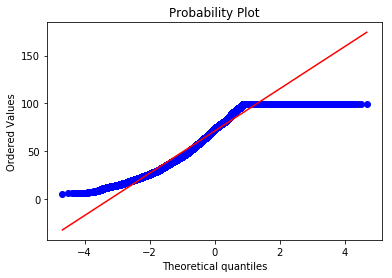

In [130]:
from scipy.stats import probplot
print(df_sds011.shape)
print('----------------')
temp = df_dht22.groupby(level=1).mean().sort_index()
print(temp.shape)
print(temp.isnull().sum())

from scipy.stats import loggamma

fig = plt.figure()
ax = fig.add_subplot(111)

print(temp['humidity'].describe())
probplot(temp['humidity'].values, plot=ax)



#np.mean(preprocessing.normalize(temp['P1'].values.reshape(1,-1))), np.std(preprocessing.normalize(temp['P1'].values.reshape(1,-1)))

# Resample and Merge

In [131]:
#def resample(df, freq='60min'):
#    level_values = df.index.get_level_values
#    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

In [9]:
print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = df_sds011.groupby(level=1).mean().sort_index()
df_dht22 = df_dht22.groupby(level=1).mean().sort_index()

df_sds011 = df_sds011.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
df_dht22 = df_dht22.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()

print(df_sds011.shape)
print(df_dht22.shape)

#print(temp.describe())
#print(temp.shape)
#temp = temp.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
#print(temp.shape)
#print(temp.describe())


#temp = temp[temp.index < '2018-11-16']
#temp = temp[temp.humidity <= 70.0]

#bound = 70#50

#s = temp.humidity
#t = temp.index

#supper = np.ma.masked_where(s >= bound, s)
#srest = np.ma.masked_where(s < bound, s)

#fig, axes = plt.subplots(nrows=1, ncols=1)
#axes.plot(t, srest, 'red', t, supper, 'green')
    
    
#fig = plt.figure()
#ax = fig.add_subplot(111)
#probplot(temp['temperature'].values, plot=ax)


(482668, 2)
(491597, 2)
(10935, 2)
(10943, 2)


In [59]:

#df_sds011 = resample(df_sds011)
#df_dht22 = resample(df_dht22)

                P1           P2  temperature     humidity
count  5020.000000  5020.000000  5020.000000  5020.000000
mean     13.918456     9.749995    17.020464    49.864443
std      13.902512     9.101169    10.651318    12.572038
min       1.277556     0.850213   -10.212500    16.062500
25%       5.338922     3.613177     8.185314    40.240292
50%       8.356633     6.095462    19.341946    50.244898
75%      16.935612    12.156530    25.380173    60.736979
max     106.982174    52.283889    41.900000    69.994521
                P1           P2  temperature     humidity
count  5912.000000  5912.000000  5912.000000  5912.000000
mean     27.194872    18.667863     9.391467    85.029505
std      19.527137    11.480568     6.010077     8.585041
min       0.968367     0.720612    -5.004000    70.020833
25%      12.284081     8.622656     5.007389    77.630462
50%      23.004664    17.791540     7.942066    84.655612
75%      36.557223    26.793724    12.700744    92.324099
max     111.57

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a5253fa58>]],
      dtype=object)

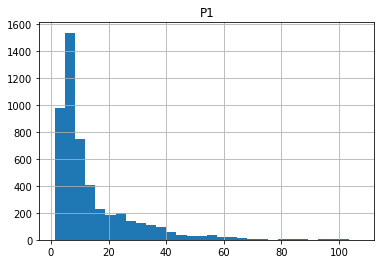

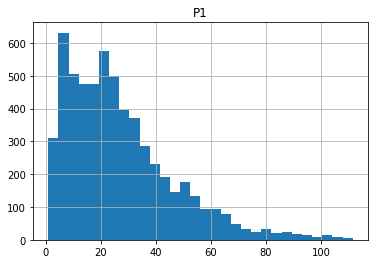

In [106]:
#data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
#print(data[data.humidity <= 70.0].describe())
#print(data[data.humidity > 70.0].describe())

#data[data.humidity <= 70.0][['P1']].hist(bins=30)
#data[data.humidity > 70.0][['P1']].hist(bins=30)

In [ ]:
print(df_sds011.shape, df_dht22.shape)

In [10]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
data = data[data.humidity <= 70.0]
print(data.isnull().sum())
print(data.shape)

P1             0
P2             0
temperature    0
humidity       0
dtype: int64
(5020, 4)


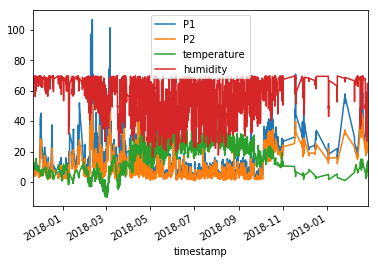

In [76]:
# data = data[data.index < '2018-11-16']
data.plot()

In [ ]:

alpha = list(data.columns.values)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()



In [ ]:
df_dht22[['temperature']].hist(bins=50, by='location')

In [ ]:
df_dht22[['humidity']].hist(bins=50, by='location')

In [ ]:
bins = int(len(range(int(df_sds011['P1'].min()), int(df_sds011['P1'].max()))) / 5 )
df_sds011[['P1']].hist(bins=bins, by='location')

In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 50

f, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

groups = list(df_sds011.groupby(level=0))


sns.distplot(groups[0][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text(groups[0][0])

sns.distplot(groups[1][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text(groups[1][0])

sns.distplot(groups[2][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text(groups[2][0])


    
plt.tight_layout()
    


In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 15


f, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

#data gets average over location 

#d = data[data['P1'] <= 15]
d = data
sns.distplot(d[['P1']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text('P1')

sns.distplot(d[['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text('P2')


sns.distplot(boxcox(d[['P1']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text('P1 boxcox')

sns.distplot(boxcox(d[['P2']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,1])

axes[1,1].title.set_text('P2 boxcox')

sns.distplot(d[['temperature']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,0])

axes[2,0].title.set_text('Temperature')

sns.distplot(d[['humidity']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,1])

axes[2,1].title.set_text('Humidity')

    
plt.tight_layout()
    

# Add add car features

In [11]:
df_cars = df_cars.groupby(pd.Grouper(freq='60min', level=0)).sum()
df_cars.shape

(483, 1)

In [12]:
car_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
df_cars['n_cars'] = car_scaler.fit_transform(df_cars['n_cars'].values.reshape(-1,1).astype('float'))
df_cars.head()

,n_cars
timestamp,
2019-02-06 17:00:00,-0.990476
2019-02-06 18:00:00,-0.961905
2019-02-06 19:00:00,-0.961905
2019-02-06 20:00:00,-0.961905
2019-02-06 21:00:00,-0.952381


# Add date features

In [13]:


day_of_week = lambda x: x.weekday()
week_number = lambda x: x.strftime('%V')
hour = lambda x: x.hour

#t = df_sds011.groupby(pd.Grouper(freq='60min', level=1)).mean().dropna()

#t.index.map(hour)[0:5]


cat_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

day_of_week = data.index.map(day_of_week).astype('int')
week_number = data.index.map(week_number).astype('int')
hour = data.index.map(hour).astype('int')


day_of_week = cat_scaler.fit_transform(onehot_encoder.fit_transform(day_of_week.values.reshape(-1,1)))
week_number = cat_scaler.fit_transform(onehot_encoder.fit_transform(week_number.values.reshape(-1,1)))
hour = cat_scaler.fit_transform(onehot_encoder.fit_transform(hour.values.reshape(-1,1)))
date_features = np.concatenate([day_of_week, week_number, hour], axis=1)

df_date = pd.DataFrame(date_features, index=data.index)
df_date.head()

,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-20 09:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 10:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 11:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 12:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 13:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Time Series

In [14]:

 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [15]:
#remove location as index, leaving only timestamp

#data = data.groupby(level=1).mean().sort_index()[['P1', 'P2', 'temperature', 'humidity']]
#data = data[['humidity', 'temperature', 'P1']]
data = data[['temperature', 'P1']]
data = series_to_supervised(data, n_in=1, n_out=1, dropnan=True)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
timestamp,,,,
2017-11-20 10:00:00,8.091667,11.602083,9.316000,11.801600
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818


In [16]:
data['diff2-1'] = data['var2(t)'] - data['var2(t-1)']
#data['diff2-2'] = data['var2(t)'] - data['var2(t-2)']
#data['diff2-3'] = data['var2(t)'] - data['var2(t-3)']

data['diff1-1'] = data['var1(t)'] - data['var1(t-1)']
#data['diff1-2'] = data['var1(t)'] - data['var1(t-2)']
#data['diff1-3'] = data['var1(t)'] - data['var1(t-3)']

data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,8.091667,11.602083,9.316000,11.801600,0.199517,1.224333
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000,-0.131600,0.721500
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000,-1.145000,-0.329167
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600,-1.179400,-0.292333
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818,-2.303782,-0.502957


In [17]:

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit_transform(data)
data = DataFrame(scaler, index=data.index, columns=data.columns)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,-0.297513,-0.804653,-0.250525,-0.800878,0.241353,-0.038831
2017-11-20 11:00:00,-0.250525,-0.800878,-0.222835,-0.803368,0.235290,-0.082213
2017-11-20 12:00:00,-0.222835,-0.803368,-0.235468,-0.825032,0.216735,-0.172860
2017-11-20 13:00:00,-0.235468,-0.825032,-0.246687,-0.847347,0.216105,-0.169683
2017-11-20 14:00:00,-0.246687,-0.847347,-0.265990,-0.890936,0.195518,-0.187854


# Combine Sensor Features with Date Features / Car Data

In [18]:
data = pd.merge(data, df_date, left_index=True, right_index=True, how='inner')
print(data.shape)
data.head()

(5019, 88)


,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1,0,1,2,3,...,72,73,74,75,76,77,78,79,80,81
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-20 10:00:00,-0.297513,-0.804653,-0.250525,-0.800878,0.241353,-0.038831,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 11:00:00,-0.250525,-0.800878,-0.222835,-0.803368,0.235290,-0.082213,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 12:00:00,-0.222835,-0.803368,-0.235468,-0.825032,0.216735,-0.172860,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 13:00:00,-0.235468,-0.825032,-0.246687,-0.847347,0.216105,-0.169683,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 14:00:00,-0.246687,-0.847347,-0.265990,-0.890936,0.195518,-0.187854,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [19]:
car_data = pd.merge(df_cars, data, left_index=True, right_index=True, how='inner')
print(car_data.shape)
car_data.head()


(169, 89)


,n_cars,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1,0,1,2,...,72,73,74,75,76,77,78,79,80,81
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-07 10:00:00,0.238095,-0.568584,0.037469,-0.370533,-0.466397,-0.249903,0.300764,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 11:00:00,-0.228571,-0.370533,-0.466397,-0.320628,-0.511374,0.194175,-0.032274,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 12:00:00,0.066667,-0.320628,-0.511374,-0.308940,-0.528969,0.220672,-0.118186,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 13:00:00,-0.038095,-0.308940,-0.528969,-0.311246,-0.513315,0.252849,-0.149646,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 14:00:00,-0.104762,-0.311246,-0.513315,-0.329300,-0.543553,0.208437,-0.185047,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [49]:
#X_train.shape[-1]

def create_model(batch_size, dim, stateful=True):
    if batch_size:
        inp = Input(batch_shape=(batch_size,1, dim))
    else:
        inp = Input(shape=(1,dim,))
    x = GRU(50, stateful=stateful, return_sequences=False)(inp)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    clf = Dense(1)(x)

    model = Model(inp, clf)
    feature_extractor = Model(inp, x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model, feature_extractor

def create_pre_trained_model(old_model):
    feature_extractor = Model(old_model.inputs, old_model.layers[-2].output)  

    for l in feature_extractor.layers:
        l.trainable = False

    inp_car = Input(shape=(1,))
    x = Dense(5, name='car-features')(inp_car)
    x = Dropout(0.2)(x)
    x = concatenate([feature_extractor.output, x])
    x = Dense(1, activation='sigmoid')(x)
    new_model = Model(inputs=[feature_extractor.input, inp_car], outputs=x)
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model

def create_data(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    y_train = train[['var2(t)']].values
    X_train = train.drop(columns=['var2(t)']).values

    X_test = test.drop(columns=['var2(t)']).values
    y_test = test[['var2(t)']].values

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, X_test, y_train, y_test

def predict_baseline(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    ### Persistence Baseline
    baseline = mean_squared_error(test['var2(t-1)'].values, test['var2(t)'].values)
    print('Persistence Baseline %.6f' % baseline)
    return baseline, test[['var2(t-1)', 'var2(t)']]


def train_normal(X_train, X_test, y_train, y_test):
    model, _ = create_model(None, X_train.shape[-1], stateful=False)
    model.fit(X_train, y_train, epochs=50000, shuffle=True, batch_size=len(X_train), validation_data=(X_test, y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    return model, model

def train_timeseries(X_train, X_test, y_train, y_test):
    train_model, _= create_model(len(X_train), X_train.shape[-1])
    test_model, _ = create_model(len(X_test), X_train.shape[-1])

    pbar = tqdm(range(10000), leave=True)

    for i in pbar:
        train_model.fit(X_train, y_train, epochs=1, shuffle=False, batch_size=len(X_train), verbose=0)
        train_model.reset_states()

        test_model.set_weights(train_model.get_weights())
        r = test_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=0)
        pbar.set_description("Test: %.6f" % r)
    return train_model, test_model


def train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, model):
    hist = model.fit([X_train, X_car_train], y_train, epochs=500, shuffle=True, batch_size=(len(X_train)), validation_data=([X_test, X_car_test], y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    
    pred = model.predict([X_test, X_car_test], batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
    
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    return mse, df, model, hist

def predict(X_train, X_test, y_train, y_test, train_fn):

    result = {}

    train_model, test_model = train_fn(X_train, X_test, y_train, y_test)

    pred = test_model.predict(X_test, batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
        
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    
    return mse, df, train_model, test_model


def plot_eval(df, test):
    test[['var2(t-1)', 'var2(t)']].plot(figsize=(25,5))
    df.plot(figsize=(25,5))

kfold = KFold(5, shuffle=False, random_state=SEED)

results_ts = []
results_norm = []
for train, test in kfold.split(data):
    
    train, test = data.iloc[train], data.iloc[test]
    #baseline, baseline_df = predict_baseline(train, test)
    
    X_train, X_test, y_train, y_test = create_data(train, test)
    
    #TODO plot history
    
    #mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_timeseries)
    #results_ts.append((baseline, mse, baseline_df, df, train_model, test_model, test))
    
    #mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_normal)
    #results_norm.append((baseline, mse, baseline_df, df, train_model, test_model, test))

    

    
results_pt_norm = []
for train, test in kfold.split(car_data):

    train, test = car_data.iloc[train], car_data.iloc[test]
    
    X_car_train = train['n_cars'].values
    X_car_test = test['n_cars'].values
    
    train = train.drop(columns=['n_cars'])
    test = test.drop(columns=['n_cars'])
    
    X_train, X_test, y_train, y_test = create_data(train, test)
    
    test_model, _ = create_model(None, X_train.shape[-1], False)
    pretrained_model = create_pre_trained_model(test_model)
        
    mse, df, pretrained_model, hist = train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, pretrained_model)
    print(mse)
    
    

    
    

    

def print_res(results):
    print('Baseline mse %.5f (%.5f STD)' % (np.mean(results[:,0]), np.std(results[:,0])))
    print('Model mse %.5f (%.5f STD)' % (np.mean(results[:,1]), np.std(results[:,1])))
    
    
#results_ts = np.asarray(results_ts)
#results_norm = np.asarray(results_norm)
 
#print_res(results_ts)
#print_res(results_norm)



0.19580685849033885


0.0468424807600701


KeyboardInterrupt: 

In [41]:
print_res(results_ts)
print_res(results_norm)

Baseline mse 0.00447 (0.00250 STD)
Model mse 0.06477 (0.04833 STD)
Baseline mse 0.00447 (0.00250 STD)
Model mse 0.00255 (0.00085 STD)


In [42]:
print(results_ts[:,0])
print(results_ts[:,1])
print(results_norm[:,1])

[0.006341295267777375 0.006649506661982893 0.0017301251562027852
 0.0010998690210343002 0.006510042855764107]
[0.1300992238071394 0.06419113312265266 0.007724743302069609
 0.015493942663344846 0.10632023212863488]
[0.0030238005649504906 0.0031726017834707867 0.0012237680398313599
 0.0034502667544637137 0.001898471904575545]


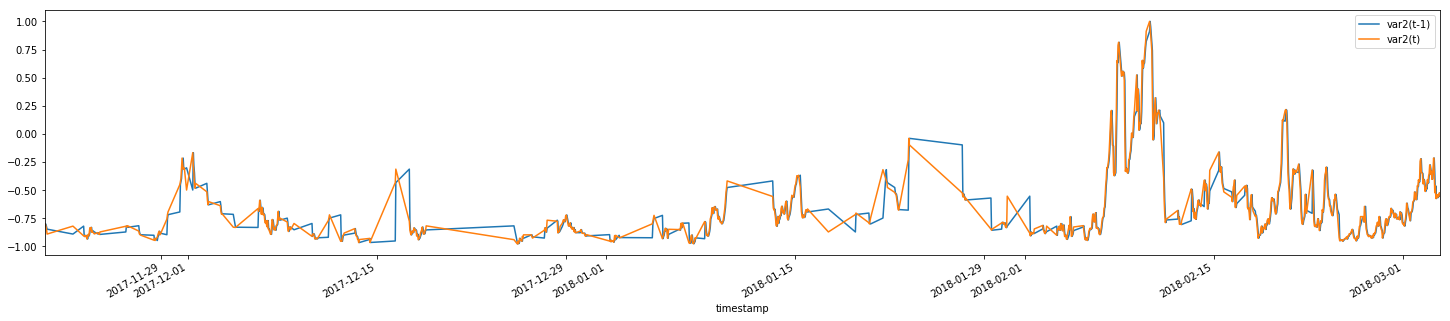

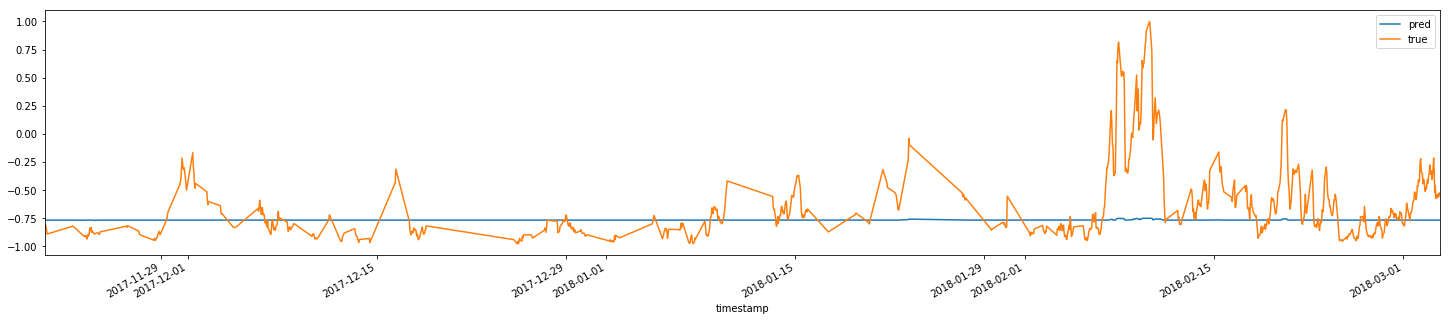

In [43]:
plot_eval(results_ts[0][3], results_ts[0][-1])

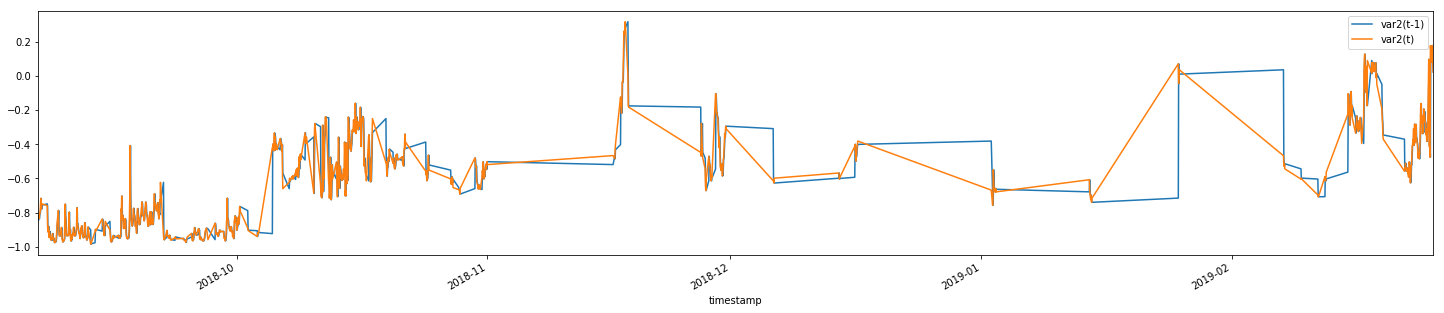

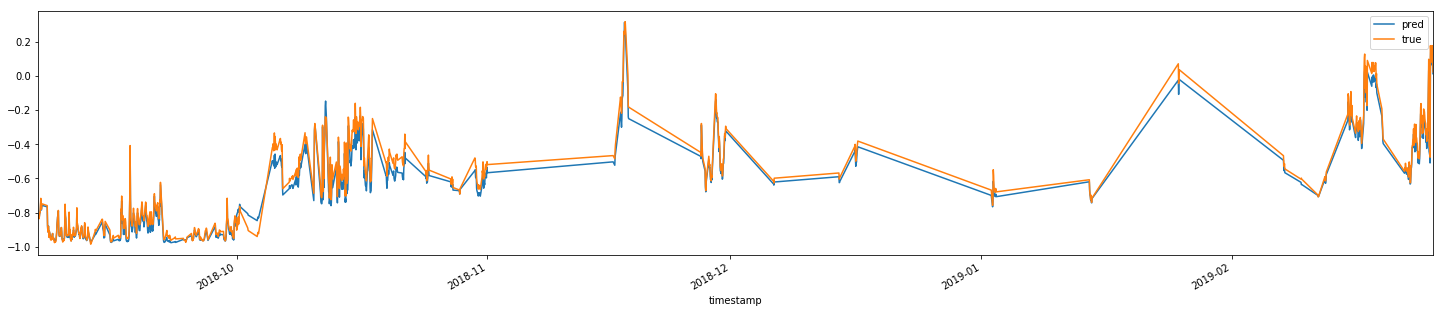

In [48]:
plot_eval(results_norm[4][3], results_norm[4][-1])

Performance

Baseline mse 0.00447 (0.00250 STD)  
Model mse 0.03598 (0.03145 STD)  
Baseline mse 0.00447 (0.00250 STD)  
Model mse 0.00182 (0.00102 STD)  

# Check for Random Walk, Stationarity ...

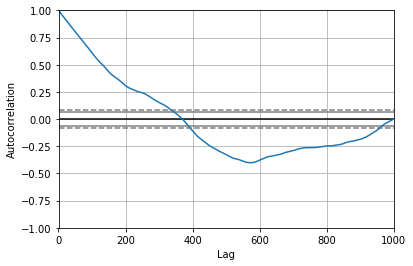

In [345]:


seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
#pyplot.plot(random_walk)
autocorrelation_plot(random_walk)
pyplot.show()

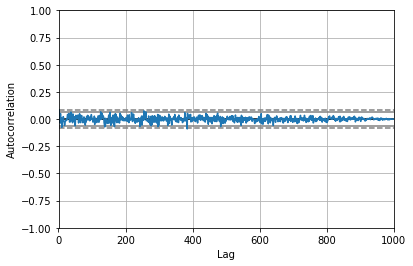

In [347]:

series = [randrange(10) for i in range(1000)]
autocorrelation_plot(series)


In [371]:

# statistical test
result = adfuller(d['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.633108
p-value: 0.086346
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


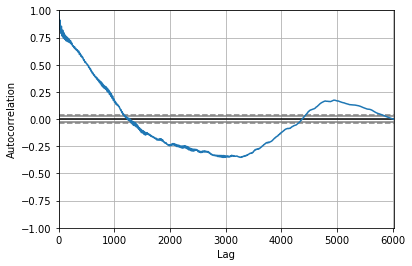

In [370]:
autocorrelation_plot(d['temperature'])

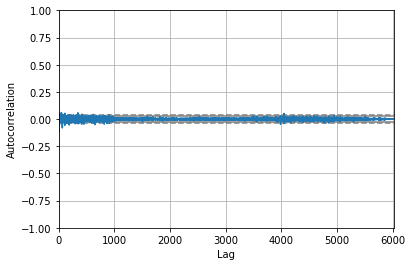

In [367]:
values = []
for t in range(1, len(d['P1'])):
    value = d['P1'].values[t] - d['P1'].values[t - 1]
    values.append(value)

#pyplot.plot(values)
#pyplot.show()
autocorrelation_plot(values)